In [1]:
# Analysis of classes from learn_ELGz.ipynb

In [1]:
import pickle
import numpy as np
import jplus
import get_3dhst as hst
from astropy.io import fits
import elgtools as elg
import MockJPLUS as mtools
import matplotlib
import matplotlib.pyplot as plt
import Read_Mocks as read



pred_file = 'classification'
pred_dict = pickle.load(open(pred_file))

pred = pred_dict['pred']
dcat = pred_dict['all']

sigmafile = 'sigma_curves.data'
sigmadict = pickle.load(open(sigmafile))



In [2]:
noii = len(np.where(np.asarray(pred) == 'OII')[0])
noiiihb = len(np.where(np.asarray(pred) == 'OIII+Hbeta')[0])
ncont = len(np.where(np.asarray(pred) == 'contaminant')[0])

print 'Number of\nOII emitters:%d\nOIII-HB emitters:%d\nContaminants:%d'%(
    noii,noiiihb,ncont)





Number of
OII emitters:15752
OIII-HB emitters:54054
Contaminants:15147


41.9235882537 43.4039084279
ntiles 484
306553480.536
[  9.78622064e-08   4.37653092e-07   1.40723599e-06   2.23446085e-06
   2.24396520e-06   1.69753243e-06   1.04437311e-06   6.22363967e-07
   3.37431512e-07   1.98424188e-07   1.38398060e-07   1.08190740e-07
   7.29421820e-08   4.61326865e-08   3.26207355e-08]


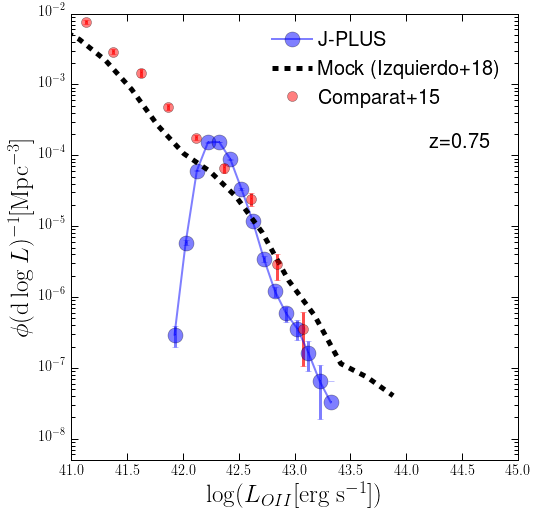

In [3]:
%matplotlib inline
from astropy.cosmology import Planck15

ld= Planck15.luminosity_distance(0.75).value

#compute LFs
mpc2cm= 3.08e24
ld *= mpc2cm
id_oii = np.asarray(pred) == 'OII'

gal_oii = jplus.tools.select_object(dcat,id_oii)

f_oii = gal_oii['F_j0660']

loii = f_oii * 4*np.pi*ld**2

min_oii = np.min(np.log10(loii))
max_oii = np.max(np.log10(loii))
lbin = 0.1
nbins = int(np.floor((max_oii-min_oii)/lbin+1))
print min_oii,max_oii
binarr = np.arange(nbins)*lbin + min_oii

phi, lbb = np.histogram(np.log10(loii),bins=nbins,range=[min_oii-lbin/2.,max_oii+lbin/2.])

depth = Planck15.comoving_distance(0.8) - Planck15.comoving_distance(0.74)
area_tile = (1.4*60)**2 #deg^2
ntiles = len(np.unique(dcat['tile_id']))
print 'ntiles %d'%ntiles
mask_factor = 0.8 #to be computed properly
area_survey = area_tile*ntiles*mask_factor*(Planck15.kpc_comoving_per_arcmin(0.77).value/(1e3))**2
volume = area_survey * depth.value
print volume

errs =np.sqrt(phi)/(volume * lbin)
print errs

plt.figure('LFOII',figsize=(8,8))
ax = plt.subplot(111)

ax.semilogy(binarr, phi/volume/lbin,'bo-',linewidth=2,markersize=15,label='J-PLUS',alpha=0.5)
ax.errorbar(binarr, phi/volume/lbin, yerr = errs, fmt='b,',alpha=0.5,elinewidth=3)
ax.set_ylabel(r'$\phi ({\rm d}\log L)^{-1}[{\rm Mpc^{-3}]$',fontsize=25)
ax.set_xlabel(r'$\log(L_{OII} [{\rm erg~s^{-1}}])$',fontsize=25)


fmockdata = 'data/z_0.7875'
fcomparatdata = 'data/z_0.7875_data'

mockphi = np.loadtxt(fmockdata)
dataphi = np.loadtxt(fcomparatdata)

ax.semilogy(mockphi[:,0],mockphi[:,1],'k--',linewidth=5,label='Mock (Izquierdo+18)')
ax.semilogy(dataphi[:,0],dataphi[:,1],'ro',markersize=10,label='Comparat+15',alpha=0.5)
ax.errorbar(dataphi[:,0],dataphi[:,1],yerr=[dataphi[:,5],dataphi[:,4]], fmt='r,',alpha=0.7,
            elinewidth=3)
ax.set_xlim([41,45])
ax.set_ylim([5e-9,1e-2])
ax.text(0.8,0.7,'z=0.75',transform=ax.transAxes,fontsize=20)
ax.legend(loc='upper right',fontsize=20)


In [67]:
# Perform completeness correction on that LF
import multiprocessing as mp
from scipy import interpolate

sigmadict.keys()
names_filters = ['uJAVA' , 'J0378', 'J0395', 'J0410', 'J0430', 'gSDSS',
                 'J0515', 'rSDSS', 'J0660', 'iSDSS', 'J0861', 'zSDSS']

suff = 'SDSS'
sdss_mw     = [3543, 4770, 6231, 7625, 9134]
alltiles = sigmadict['tiles']
ntiles = len(alltiles)


gcat = gal_oii # Use all objects in gcat to sample completeness
magrrange = [20,24] #Magnitude range in r band
nmags     = 20 #Sample each magnitude bin nmags times
nl = 10
noff = 1.0

nboff = np.linspace(-noff,noff,nl)

magr_arr = np.tile(np.linspace(magrrange[0],magrrange[1],nmags),nl)
rbin = magr_arr[1] - magr_arr[0]

ptile = 55
pgal = 234
DoPlots = False

from astropy.cosmology import Planck15
ld= Planck15.luminosity_distance(0.75).value

mpc2cm= 3.08e24
ld *= mpc2cm


nproc = 8  # number of parallel processes
i0 = 0  # file sub-volumes
i1 = ntiles
npp = int((i1-i0+1.0)/(nproc+0.0))


min_oii = 41.0
max_oii = 44.0
lbin = 0.1
nbins = int(np.floor((max_oii-min_oii)/lbin+1))
print min_oii,max_oii
binarr = np.arange(nbins)*lbin + min_oii
comp_tile = np.zeros([ntiles,nbins])
comp_funcs = []
#for it in range(ntiles):
gj0660 = 2.0

for it in range(ntiles):
    
    tt = alltiles[it]
    sdata = sigmadict['sfunc'][it]    
    tsel = (gcat['tile_id'] == tt)
    gtile = jplus.tools.select_object(gcat,tsel)
    ng = len(gtile['tile_id'])
    
    sfunc = interpolate.interp1d(sdata[0], sdata[1], 
                                 fill_value = 'extrapolate')
    
    test_gals = {}
    for mag in names_filters:
        test_gals[mag] = np.zeros(ng*nmags*nl)
    
    ik = 0 #counter
    for ig in range(ng): # Re-sampling each galaxy
        magr_ig = gtile['rSDSS'][ig,0]
        if ig == pgal and it == ptile and DoPlots:
            plt.figure('sample')
        for mag in names_filters:
            mf = gtile[mag][ig,0] + (magr_arr - magr_ig)
            mdelta = np.random.normal(0, gtile[mag][ig,1])
            test_gals[mag][ik:ik+nmags*nl] = mf + mdelta
            if mag == 'J0660':
                for iil in range(nl):
                    test_gals[mag][ik+nmags*iil:ik+nmags*(iil+1)] += np.tile(nboff[iil],nmags)
                if ig ==0 and it ==0:
                    print  test_gals[mag][ik:ik+nmags*nl]
                    print np.tile(nboff,nmags)
                    print mf
            
            if ig ==pgal and it == ptile and DoPlots:
                if 'SDSS' not in mag:
                    filt = jplus.tools.fetch_jplus_filter(mag, quiet=True)
                    ww = filt.avgwave()
                else:
                    filt = jplus.tools.fetch_sdss_filter(mag, quiet=True)
                    ww = [filt[0,filt[1,:].argmax()],filt[0,filt[1,:].argmax()]]
                    
                plt.plot([ww]*nmags,test_gals[mag][ik:ik+nmags],'.',color='red')
                plt.ylim([17,23])
        
        ik += nmags*nl
        
    # compute 3FM for all resampled galaxies in tile
    
    dm, fline, fcont = mtools.gen_3fm(test_gals['J0660'],  
                    test_gals['r'+suff], test_gals['g'+suff], 
                    Broad_NoLineName='g'+suff)
    test_gals['dm'] = dm
    test_gals['lum_line'] = np.log10(fline * 4*np.pi*ld**2) # All objects are assumed at z=0.75
    #print test_gals['lum_line'].min(), test_gals['lum_line'].max()
    # group by luminosity
    if it ==0:
        print 'i_tile, lum, completeness, rSDSS'
    for ibb in range(nbins):
        sel = ((test_gals['lum_line'] > binarr[ibb] - lbin/2.) & 
               (test_gals['lum_line'] < binarr[ibb] + lbin/2.) 
               )
        
        ntot_l = len(np.where(sel)[0])
        if ntot_l == 0:
            continue
        
        # Apply selection criteria
        selc = ((test_gals['dm'][sel] > sfunc(test_gals['rSDSS'][sel])) &
               (test_gals['dm'][sel] >0.4))
              # (test_gals['gSDSS'][sel] - test_gals['J0660'][sel] < gj0660))

             
        nsel = len(np.where(selc)[0])
        comp_tile[it,ibb] = float(nsel)/float(ntot_l)
        if it < 3:
            print it, binarr[ibb], comp_tile[it,ibb], np.mean(test_gals['rSDSS'][sel][selc])
        compf = interpolate.interp1d(binarr, comp_tile[it,:],fill_value='extrapolate')
    
    comp_funcs.append([tt, compf])             
        
print 'done!'    

41.0 44.0
[ 18.04958303  18.26010935  18.47063566  18.68116198  18.89168829
  19.10221461  19.31274093  19.52326724  19.73379356  19.94431987
  20.15484619  20.3653725   20.57589882  20.78642514  20.99695145
  21.20747777  21.41800408  21.6285304   21.83905671  22.04958303
  18.27180525  18.48233157  18.69285788  18.9033842   19.11391052
  19.32443683  19.53496315  19.74548946  19.95601578  20.16654209
  20.37706841  20.58759473  20.79812104  21.00864736  21.21917367
  21.42969999  21.64022631  21.85075262  22.06127894  22.27180525
  18.49402747  18.70455379  18.91508011  19.12560642  19.33613274
  19.54665905  19.75718537  19.96771169  20.178238    20.38876432
  20.59929063  20.80981695  21.02034326  21.23086958  21.4413959
  21.65192221  21.86244853  22.07297484  22.28350116  22.49402747
  18.7162497   18.92677601  19.13730233  19.34782864  19.55835496
  19.76888128  19.97940759  20.18993391  20.40046022  20.61098654
  20.82151285  21.03203917  21.24256549  21.4530918   21.66361812
 

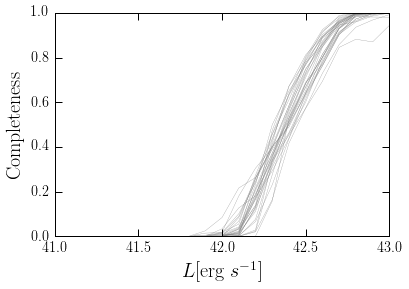

In [68]:
plt.figure('completeness')

for it in range(nbins):
    plt.plot(binarr, comp_tile[it,:],'-',linewidth=0.25,color='gray')
    
plt.xlim([41,43])
plt.xlabel(r'$L[{\rm erg}\ s^{-1}]$',fontsize=20)
plt.ylabel(r'${\rm Completeness}$',fontsize=20)

plt.show()

41.9235882537 43.4039084279
ntiles 484
306553480.536
[  9.78622064e-08   4.37653092e-07   1.40723599e-06   2.23446085e-06
   2.24396520e-06   1.69753243e-06   1.04437311e-06   6.22363967e-07
   3.37431512e-07   1.98424188e-07   1.38398060e-07   1.08190740e-07
   7.29421820e-08   4.61326865e-08   3.26207355e-08]
0 42.4811587505 1.52679548902
0 42.0810903452 5.22246834415
0 42.0982118463 4.67007336419
0 42.2682429016 2.86565488898
0 42.1014312785 4.60484186079
0 42.2209839659 3.45373939613
0 42.1242654387 4.3894718886
0 42.2483574302 3.08681825285
0 42.3673926995 2.10106514306
0 42.3521013736 2.19204403576
0 42.2414071054 3.17239297335
0 42.1686514945 4.02366354912


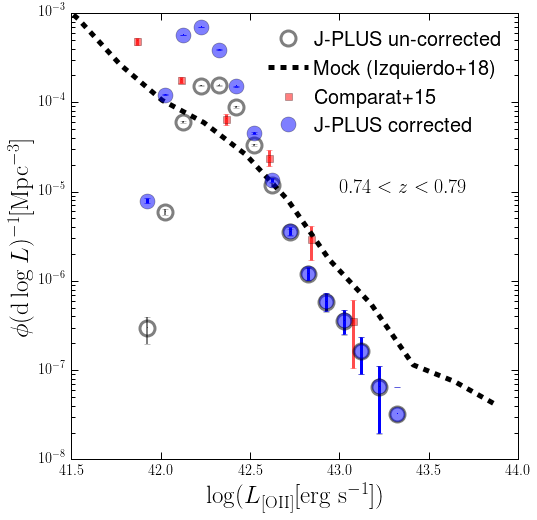

In [69]:
# Now compute that LF again using the completeness curves

%matplotlib inline
from astropy.cosmology import Planck15

ld= Planck15.luminosity_distance(0.75).value

#compute LFs
mpc2cm= 3.08e24
ld *= mpc2cm
id_oii = np.asarray(pred) == 'OII'

gal_oii = jplus.tools.select_object(dcat,id_oii)

f_oii = gal_oii['F_j0660']

loii = f_oii * 4*np.pi*ld**2

min_oii = np.min(np.log10(loii))
max_oii = np.max(np.log10(loii))
lbin = 0.1
nbins = int(np.floor((max_oii-min_oii)/lbin+1))
print min_oii,max_oii
binarr = np.arange(nbins)*lbin + min_oii

phi, lbb = np.histogram(np.log10(loii),bins=nbins,range=[min_oii-lbin/2.,max_oii+lbin/2.])

depth = Planck15.comoving_distance(0.8) - Planck15.comoving_distance(0.74)
area_tile = (1.4*60)**2 #deg^2
ntiles = len(np.unique(dcat['tile_id']))
print 'ntiles %d'%ntiles
mask_factor = 0.8 #to be computed properly
area_survey = area_tile*ntiles*mask_factor*(Planck15.kpc_comoving_per_arcmin(0.77).value/(1e3))**2
volume = area_survey * depth.value
print volume

errs =np.sqrt(phi)/(volume * lbin)
print errs

plt.figure('LFOII',figsize=(8,8))
ax = plt.subplot(111)

ax.semilogy(binarr, phi/volume/lbin,'ko',linewidth=2,markersize=15,label='J-PLUS un-corrected',
            alpha=0.5,mfc='none',mew=3)
ax.errorbar(binarr, phi/volume/lbin, yerr = errs, fmt='k,',alpha=0.5,elinewidth=2)
ax.set_ylabel(r'$\phi ({\rm d}\log L)^{-1}[{\rm Mpc^{-3}]$',fontsize=25)
ax.set_xlabel(r'$\log(L_{\rm [OII]} [{\rm erg~s^{-1}}])$',fontsize=25)


fmockdata = 'data/z_0.7875'
fcomparatdata = 'data/z_0.7875_data'

mockphi = np.loadtxt(fmockdata)
dataphi = np.loadtxt(fcomparatdata)

ax.semilogy(mockphi[:,0],mockphi[:,1],'k--',linewidth=5,label='Mock (Izquierdo+18)')
ax.semilogy(dataphi[:,0],dataphi[:,1],'rs',markersize=7,label='Comparat+15',alpha=0.5)
ax.errorbar(dataphi[:,0],dataphi[:,1],yerr=[dataphi[:,5],dataphi[:,4]], fmt='r,',alpha=0.7,
            elinewidth=3)


#Now the corrected LF:

# Get the weights for each galaxy first
ntot = len(gal_oii['tile_id'])
gal_oii['weight_c'] = np.zeros(ntot)
for it in range(ntiles):
    tt = alltiles[it]
    gsel = np.where(gal_oii['tile_id'] == tt)[0]
    cf = comp_funcs[it][1]
    ngal = len(gsel)
    for ig in range(ngal):
        iid = gsel[ig]
        gal_oii['weight_c'][iid] = 1 if cf(np.log10(loii[iid])) == 0 else 1./cf(np.log10(loii[iid]))
        
        if it ==0:
            print it,np.log10(loii[iid]), gal_oii['weight_c'][iid]
    

phi2, lbb2 = np.histogram(np.log10(loii),bins=nbins,
                          range=[min_oii-lbin/2.,max_oii+lbin/2.],
                         weights = gal_oii['weight_c'])

errs2 =np.sqrt(phi2)/(volume * lbin)

ax.semilogy(binarr, phi2/volume/lbin,'bo',linewidth=2,markersize=15,label='J-PLUS corrected',
            alpha=0.5)
ax.errorbar(binarr, phi2/volume/lbin, yerr = errs2, fmt='b,',alpha=1.0,elinewidth=3)


ax.set_xlim([41.5,44])
ax.set_ylim([1e-8,1e-3])
ax.text(0.6,0.6,r'$0.74<z<0.79$',transform=ax.transAxes,fontsize=20)
ax.legend(loc='upper right',fontsize=20)







In [26]:
print phi2/volume/lbin

[  3.17772274e-06   5.09502033e-05              inf   4.74910581e-04
              inf   2.10649860e-04   7.68136649e-05   2.50554870e-05
   7.40343084e-06   2.77585471e-06   1.30728944e-06   8.87125960e-07
   6.28452183e-07   1.80046287e-07   8.34625496e-07]


In [5]:
import pymangle
generate_random_mask = False

if generate_random_mask:

    jpm_file = '/home/CEFCA/aaorsi/work/jplus_masks/jplus_dr1_masks.pol'
    print jpm_file
    jplus_mask = pymangle.mangle.Mangle(jpm_file)
    print 'creating randoms'
    jpran = jplus_mask.genrand(10000)
    ran_mask0 = {'coords':np.transpose([jpran[0], jpran[1]])}
else:    
    ranfile = 'random_mask.data'
    ran_mask0 = pickle.load(open(ranfile))

print ran_mask0.keys()
tiles = jplus.datasets.fetch_jplus_tile_list(db='dr1',overwrite=False)

print tiles.keys()


j-plus [INFO]: Fetching J-PLUS Tile list
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/objects_tile_list_dr1_dual.h5


['coords']
['ncombined', 'noise', 'min_ra', 'ADUlevel', 'tileIDs', 'texposed', 'min_dec', 'ref_tileID', 'filter', 'depth', 'effectime', 'max_dec', 'ra', 'SQL', 'date', 'max_ra', 'dec', 'fwhmg']


In [6]:
tile_scale = 1.5

def haversine_dist(ra1, dec1, ra2, dec2):
  th1 = np.pi/2. - dec1 * np.pi/180.0
  th2 = np.pi/2. - dec2 * np.pi/180.0

  ph1 = ra1 * np.pi/180.0
  ph2 = ra2 * np.pi/180.0

  dph = np.abs(ph1 - ph2)
  dth = np.abs(th1 - th2)

  harg = np.sin(dph/2)**2 + np.cos(ph1)*np.cos(ph2) * np.sin(dth/2.)**2

  return 2 *np.arcsin(np.sqrt(harg)) * 180./np.pi  # Return distance in degrees

#Get the mask tiles overlapping with ELGs
 
    
Load_rans=True
ranfile = 'ran_jplus'
if not Load_rans:
    print 'finding tile_id of random points...'
    nran = len(ran_mask0['coords'])
    print 'initial number of randoms %ld' % nran
    ran_tile_id = np.zeros(nran)

    m = []
    for i in range(nran):
        darr = haversine_dist(ran_mask0['coords'][i,0], ran_mask0['coords'][i,1], 
                              tiles['ra'], tiles['dec'])
        idt2 = np.argsort(darr)[0]  
        ran_tile_id[i] = tiles['ref_tileID'][idt2] 
        m.append(True if darr[idt2] < tile_scale else False)
        if i%10000 == 0:
            print float(i)/float(nran)

    randict = jplus.tools.select_object(ran_mask0, m)
    randict['tile_id'] = ran_tile_id[m]

    print 'Returning only random mask tiles with overlapping tiles with ELGs'

    unique_tiles = reduce(np.intersect1d, (np.unique(gal_oii['tile_id']), 
                                           np.unique(randict['tile_id'])))
    print 'number of intersecting tiles', len(unique_tiles)

    ran_mask   = jplus.tools.select_object(randict, 
                 np.array([item in unique_tiles for item in randict['tile_id']]))
    gal_oiin   = jplus.tools.select_object(gal_oii, 
                 np.array([item in unique_tiles for item in gal_oii['tile_id']]))
    
    print 'Final number of random points in mask:%ld'%len(ran_mask['tile_id'])
    overlap = {'ran':ran_mask, 'gal_oii':gal_oiin}
    with open(ranfile,'wb') as outfile:
        pickle.dump(overlap,outfile,protocol=pickle.HIGHEST_PROTOCOL)   
    
else:
    overlap = pickle.load(open(ranfile))

ran_mask = overlap['ran']
gal_oiin = overlap['gal_oii']



In [7]:
ran_mask.keys()
len(ran_mask['tile_id'])

472676

482
482
[26319 26319 26319 26319 26319 26319 26319 26319 26319 26319 26319 26319
 26319 26319 26319 26319 26319 26319 26319 26319 26319 26319 26319 26319
 26319 26319 26319 26319 26319 26319]
[ 164.1563  164.1563  164.1563  164.1563  164.1563  164.1563  164.1563
  164.1563  164.1563  164.1563  164.1563  164.1563] [ 79.1761  79.1761  79.1761  79.1761  79.1761  79.1761  79.1761  79.1761
  79.1761  79.1761  79.1761  79.1761]
[ 160.31573339  160.31573339  160.31573339  160.31573339  160.31573339
  160.31573339  160.31573339  160.31573339  160.31573339  160.31573339
  160.31573339  160.31573339] [ 168.33718111  168.33718111  168.33718111  168.33718111  168.33718111
  168.33718111  168.33718111  168.33718111  168.33718111  168.33718111
  168.33718111  168.33718111]
[ 78.43723665  78.43723665  78.43723665  78.43723665  78.43723665
  78.43723665  78.43723665  78.43723665  78.43723665  78.43723665
  78.43723665  78.43723665] [ 79.88809084  79.88809084  79.88809084  79.88809084  79.88809084
  79

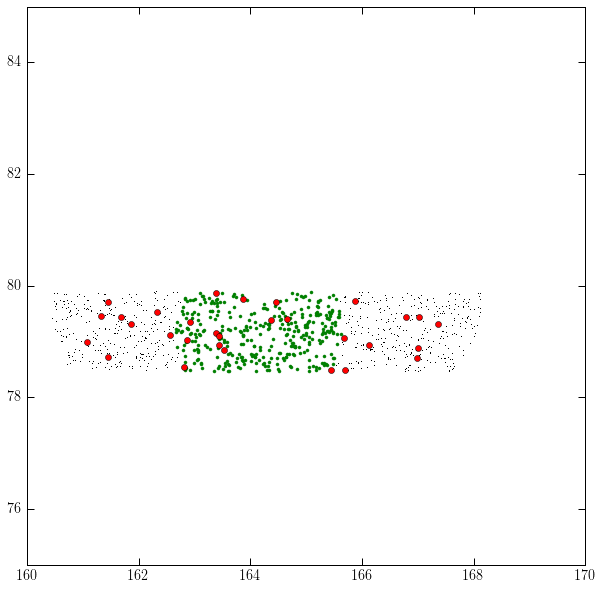

In [8]:
plt.figure(figsize=(10,10))

plt.plot(ran_mask0['coords'][:,0],ran_mask0['coords'][:,1],'k,')
plt.plot(ran_mask['coords'][:,0],ran_mask['coords'][:,1],'.',
         color='green')
plt.plot(gal_oiin['coords'][:,0],gal_oiin['coords'][:,1],'o',
         color='red')

xlim = [160,170]
ylim = [75,85]

plt.xlim(xlim)
plt.ylim(ylim)

print len(np.unique(ran_mask['tile_id']))
print len(np.unique(gal_oiin['tile_id']))

l1 = np.sort(np.unique(ran_mask['tile_id']))
l2 = np.sort(np.unique(gal_oiin['tile_id']))

sel0 =((ran_mask0['coords'][:,0] > xlim[0]) & 
       (ran_mask0['coords'][:,0] < xlim[1]) &
       (ran_mask0['coords'][:,1] > ylim[0]) &
       (ran_mask0['coords'][:,1] < ylim[1]))

sel = ((ran_mask['coords'][:,0] > xlim[0]) & 
       (ran_mask['coords'][:,0] < xlim[1]) &
       (ran_mask['coords'][:,1] > ylim[0]) &
       (ran_mask['coords'][:,1] < ylim[1]))

gsel = ((gal_oiin['coords'][:,0] > xlim[0]) & 
       (gal_oiin['coords'][:,0] < xlim[1]) &
       (gal_oiin['coords'][:,1] > ylim[0]) &
       (gal_oiin['coords'][:,1] < ylim[1]))

#print np.unique(randict['tile_id'][sel0])
ut = np.unique(ran_mask['tile_id'][sel])
print gal_oiin['tile_id'][gsel]
tt = np.where(tiles['ref_tileID'] == ut)
print tiles['ra'][tt], tiles['dec'][tt]
print tiles['min_ra'][tt], tiles['max_ra'][tt]
print tiles['min_dec'][tt], tiles['max_dec'][tt]



[26209 26209 26209]
26209
[False False False ..., False False False]


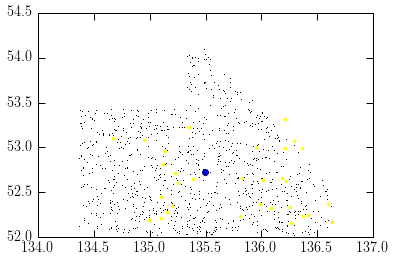

In [9]:
suspects = ((gal_oiin['coords'][:,0] > 135) & (gal_oiin['coords'][:,0] < 136) & 
            (gal_oiin['coords'][:,1] > 50) & (gal_oiin['coords'][:,1] <53 ))

stile =gal_oiin['tile_id'][suspects][0]
print gal_oiin['tile_id'][suspects]
print stile

ss = dcat['tile_id'] == stile
rr = ran_mask['tile_id'] == stile
tt = tiles['ref_tileID'] == stile
plt.figure('xxx')
plt.plot(ran_mask['coords'][rr,0],ran_mask['coords'][rr,1],'k,')
#plt.plot(ran_mask['coords'][:,0],ran_mask['coords'][:,1],',',color='green')


plt.plot(dcat['coords'][ss,0],dcat['coords'][ss,1],'.',color='yellow')
plt.plot([tiles['ra'][tt][0],tiles['ra'][tt][0]],
         [tiles['dec'][tt][0],tiles['dec'][tt][0]],'o')


print tt


In [10]:
print np.multiply(tiles['ra'][tt][0],[1,1])

[ 135.4943  135.4943]


'\nplt.figure(5)\nrMin = 1.0\nrMax = 20.0\npiMin = 0.\npiMax = 0.\nproj_tpf = cbl.TwoPointCorrelation_projected(cat_objs, ran_objs,cbl.EnumTypes._linear_, rMin, rMax, nbins, shift, \n                                        angularUnits)\n\ncbl.set_ObjectRegion_SubBoxes(cat_objs,ran_objs,3,3,3)\nproj_tpf.measure(cbl.EnumTypes._Jackknife_,\'./\')\nproj_tpf.write(\'./\', \'test\')\n\nplt.errorbar(proj_tpf.xx(), proj_tpf.xi1D(), proj_tpf.error1D(), fmt=\'o\',color=\'royalblue\', label="2pt monopole")\nplt.legend()\nplt.xlabel(r\'$r_p$\',fontsize=20)\nplt.ylabel(r\'$w_p(r_p)$\',fontsize=20)\nplt.savefig(\'wp_rp.pdf\',bbox_inches=\'tight\')\n\n'

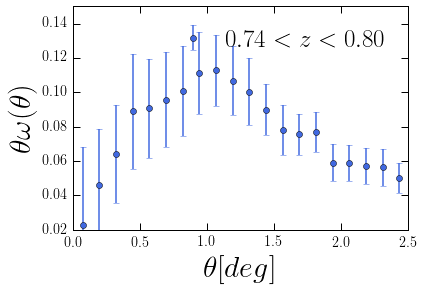

In [23]:
# Raw 2PCF:

readw = False

import CosmoBolognaLib as cbl
cosmology = cbl.Cosmology()

ran_mask['redshift'] = np.ones(len(ran_mask['coords']))
gal_oiin['redshift'] = np.ones(len(gal_oiin['coords']))

ra_mask = ran_mask['coords'][:,0].astype(float)
dec_mask = ran_mask['coords'][:,1].astype(float)

if readw is False:
    cat_objs = cbl.Catalogue(cbl.EnumTypes._Galaxy_, cbl.EnumTypes._observedCoordinates_, 
                            gal_oiin['coords'][:,0],gal_oiin['coords'][:,1],gal_oiin['redshift'], 
                             cosmology, cbl.EnumTypes._degrees_)

    ran_objs = cbl.Catalogue(cbl.EnumTypes._RandomObject_, cbl.EnumTypes._observedCoordinates_,
                            ra_mask,dec_mask, ran_mask['redshift'], cosmology, 
                             cbl.EnumTypes._degrees_)



    angMin = 0.01                #// minimum angular separation 
    angMax = 2.5                  #// maximum angular separation 
    nbins = 20                      #// number of bins
    shift = 0.5                  #// shift used to set the bin centre 
    angularUnits = cbl.EnumTypes._degrees_

    twopt = cbl.TwoPointCorrelation1D_angular(cat_objs, ran_objs,cbl.EnumTypes._linear_, angMin, angMax, nbins, shift, 
                                            angularUnits)
    cbl.set_ObjectRegion_SubBoxes(cat_objs,ran_objs,3,3,3)

    twopt.measure(cbl.EnumTypes._Jackknife_,'./')
    twopt.write('./', 'test');
    xx = np.asarray(twopt.xx())
    xi1D = np.asarray(twopt.xi1D())
    error1D = np.asarray(twopt.error1D())
else:
    xx, xi1D, error1D = np.loadtxt('test',unpack=True)
    
#plt.figure(4,figsize=(7,7))
fig,ax = plt.subplots(1)
ax.errorbar(xx, xx*xi1D, error1D, fmt='o',
             color='royalblue', label=r'$%.2f<z<%.2f$'%(0.74,0.8))
ax.legend(fontsize=25)
ax.set_ylim([0.02,0.15])
#plt.yscale('log')
#plt.xscale('log')

ax.set_xlabel(r'$\theta [deg]$',fontsize=30)
ax.set_ylabel(r'$\theta\omega(\theta)$',fontsize=30)
plt.savefig('w_elgcand.pdf',bbox_inches='tight')

"""
plt.figure(5)
rMin = 1.0
rMax = 20.0
piMin = 0.
piMax = 0.
proj_tpf = cbl.TwoPointCorrelation_projected(cat_objs, ran_objs,cbl.EnumTypes._linear_, rMin, rMax, nbins, shift, 
                                        angularUnits)

cbl.set_ObjectRegion_SubBoxes(cat_objs,ran_objs,3,3,3)
proj_tpf.measure(cbl.EnumTypes._Jackknife_,'./')
proj_tpf.write('./', 'test')

plt.errorbar(proj_tpf.xx(), proj_tpf.xi1D(), proj_tpf.error1D(), fmt='o',color='royalblue', label="2pt monopole")
plt.legend()
plt.xlabel(r'$r_p$',fontsize=20)
plt.ylabel(r'$w_p(r_p)$',fontsize=20)
plt.savefig('wp_rp.pdf',bbox_inches='tight')

"""

['flags_aper3_gauss_uJAVA', 'flags_aper3_gauss_J0378', 'dm_j0660', 'J0861', 'flags_aper3_worstpsf_J0378', 'fwhm', 'cstar', 'flags_aper3_worstpsf_J0515', 'mag_auto_r', 'mask_flags_J0515', 'single_detect_J0395', 'uJAVA', 'dm', 'F_j0660', 'single_detect_zJAVA', 'flags_aper3_gauss_J0515', 'gJAVA', 'norm_wmap_val_J0378', 'J0378', 'norm_wmap_val_rJAVA', 'single_detect_J0515', 'flags_aper3_gauss_iJAVA', 'flag_J0430', 'flags_aper3_gauss_zJAVA', 'flag_uJAVA', 'flags_aper3_worstpsf_J0861', 'elgcand', 'mask_flags_J0660', 'J0515', 'flags_aper3_worstpsf_J0410', 'mask_flags_gJAVA', 'flags_aper3_worstpsf_J0430', 'filename', 'single_detect_gJAVA', 'norm_wmap_val_iJAVA', 'flags_aper3_gauss_J0660', 'single_detect_uJAVA', 'F_cont_j0660', 'err_dm', 'mask_flags_uJAVA', 'norm_wmap_val_J0515', 'flags_aper3_gauss_J0861', 'zSDSS', 'kron_rad', 'XY_IMAGE', 'mask_flags_J0378', 'flag_J0410', 'ids', 'dm_j0660_err', 'single_detect_J0430', 'flags_aper3_worstpsf_J0395', 'rJAVA', 'flag_J0395', 'mask_flags_iJAVA', 'sing

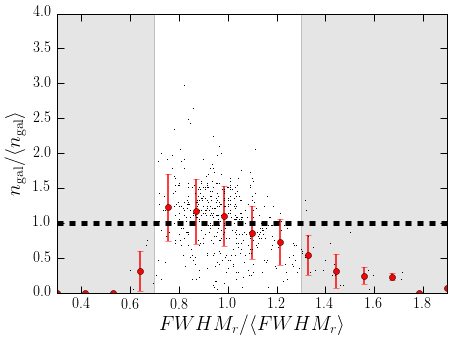

In [25]:
#Checking systematics
print gal_oii.keys()
tile, mag, total = jplus.plotting.groupbytile(gal_oiin['tile_id'], gal_oiin['J0660'][:,0])
#plt.figure()
#plt.plot(tile, mag,'o')
#print tile, total

n_avg = np.mean(total)
n_navg = total/n_avg
tile_oii, fwhm, total = jplus.plotting.groupbytile(gal_oiin['tile_id'], gal_oiin['fwhm'])

#print tiles.keys()
#plt.figure()
#plt.plot(n_navg, fwhm,'.')


def med_property(xprop,yprop,nbins,prange):
    xarr = np.linspace(prange[0],prange[1],nbins)
    yarr= np.zeros(nbins)
    pp = np.zeros(nbins)
    bs = xarr[1]-xarr[0]
    for i in range(nbins):
        ss = np.where((xprop >xarr[i] - bs/2.) & (xprop < xarr[i]+bs/2.))[0]
        if len(ss) == 0:
            continue
        yarr[i] = np.median(yprop[ss])
        pp[i] = np.std(yprop[ss])
        
    
    return xarr,yarr,pp

        
nbins= 15
prange = [0.3,1.9]

def plot_syst(f_favg, n_navg,nbins=15,prange=[0.65,1.5],
              xlabel=r'$FWHM_r/\langle FWHM_r \rangle$',
             ylabel=r'$n_{\rm gal}/\langle n_{\rm gal}\rangle$'):

    plt.figure(figsize=(7,5))
    plt.plot(f_favg, n_navg,',',color='black')
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel(ylabel,fontsize=20)
    plt.xlim(prange)
    plt.plot(prange,[1,1],'--',linewidth=5,color='black')
    xp,yp,pp = med_property(f_favg, n_navg,nbins, prange)
    #plt.plot(xp,yp,'o')
    plt.errorbar(xp,yp,yerr=pp,fmt='o',color='red')
    
    return xp,yp,pp

avg_fwhm = np.mean(fwhm)
f_favg  = fwhm / avg_fwhm

xp,yp,pp = plot_syst(f_favg, n_navg,prange=prange)

plt.fill_between([xp[0],0.7],[0,0],[4,4],facecolor='gray',alpha=0.2)
plt.fill_between([1.3,3],[0,0],[4,4],facecolor='gray',alpha=0.2)

gal_oiin['d_fwhm'] = gal_oiin['fwhm']/avg_fwhm
print 'len = %d'%len(gal_oiin['d_fwhm'])

sel = ((gal_oiin['d_fwhm'] >0.6) &
       (gal_oiin['d_fwhm'] <1.5))

print len(gal_oiin['d_fwhm'])
print 'Number of galaxies before FWHM sel:%d'%len(gal_oiin['tile_id'])
gal_oiin_fwhm = jplus.tools.select_object(gal_oiin, sel)
print 'Number of galaxies:%d'%len(gal_oiin_fwhm['tile_id'])







['ncombined', 'noise', 'min_ra', 'ADUlevel', 'tileIDs', 'texposed', 'min_dec', 'ref_tileID', 'filter', 'depth', 'effectime', 'max_dec', 'ra', 'SQL', 'date', 'max_ra', 'dec', 'fwhmg']
Number of objects of clean sample:  8406
number of intersecting tiles 368


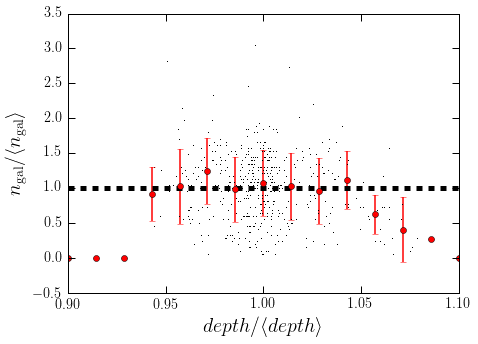

In [19]:
# get properties from tiles

print tiles.keys()


oii_tiles= np.unique(gal_oiin_fwhm['tile_id'])
gal_oiin_fwhm['depth'] = np.zeros(len(gal_oiin_fwhm['tile_id']))
for tt in oii_tiles:
    id_oii = np.where(np.asarray(gal_oiin_fwhm['tile_id']) == tt)[0]
    id_tarr = np.where(np.asarray(tiles['ref_tileID']) == tt)[0]
    gal_oiin_fwhm['depth'][id_oii] = tiles['depth'][id_tarr][5]
#    print tiles['depth'][id_tarr]
#    print 'Ngals tile and depth %d:%d'%(tt,len(id_oii))



tile_oii, depth_tiles, total = jplus.plotting.groupbytile(gal_oiin_fwhm['tile_id'], 
                                                          gal_oiin_fwhm['depth'])

#tile, mag, total = jplus.plotting.groupbytile(gal_oiin_fwhm['tile_id'], gal_oiin_fwhm['J0660'][:,0])
#plt.figure()
#plt.plot(tile, mag,'o')
#print tile, total

n_avg = np.mean(total)
n_navg = total/n_avg


avg_depth = np.mean(depth_tiles)
f_favg    = depth_tiles / avg_depth
xp,yp,pp  = plot_syst(f_favg, n_navg, 
            xlabel=r'$depth/\langle depth\rangle$',
            prange=[0.9,1.1])





#gal_oiin['d_davg'] = f_favg
from scipy import interpolate

xpr = [.94,1.07]

dn = interpolate.interp1d(xp,yp, bounds_error=False, fill_value=1e-2)

ww = 1./(dn(gal_oiin_fwhm['depth']/avg_depth))
gal_oiin_fwhm['weight'] =  ww
wws = (1./ww >xpr[0]) & (1./ww < xpr[1])

gal_oii_clean = jplus.tools.select_object(gal_oiin_fwhm, wws)
print 'Number of objects of clean sample: ', len(gal_oii_clean['tile_id'])

unique_tiles = reduce(np.intersect1d, (np.unique(gal_oii_clean['tile_id']), 
                                           np.unique(ran_mask['tile_id'])))
print 'number of intersecting tiles', len(unique_tiles)

ran_mask_clean   = jplus.tools.select_object(ran_mask, 
             np.array([item in unique_tiles for item in ran_mask['tile_id']]))





8406


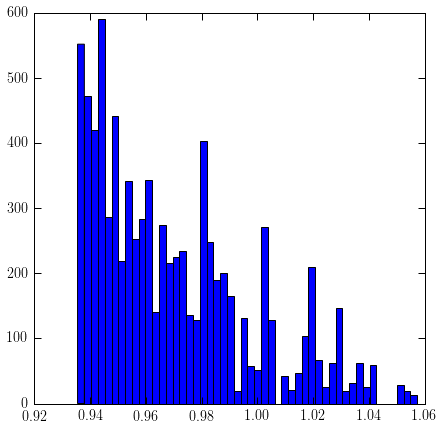

In [20]:
#gal_oii_clean['weight'] = 1./(gal_oii_clean['depth']/avg_depth)

plt.figure(figsize=(7,7))
plt.hist(gal_oii_clean['weight'],bins=50)
print len(gal_oii_clean['weight'])

[ 0.0723  0.1968  0.3213  0.4458  0.5703  0.6948  0.8193  0.9438  1.0683
  1.1928  1.3173  1.4418  1.5663  1.6908  1.8153  1.9398  2.0642  2.1888
  2.3133  2.4377] [ 0.3418  0.2482  0.2148  0.2075  0.1581  0.1413  0.1257  0.1046  0.1096
  0.0915  0.0826  0.0615  0.0554  0.0487  0.0466  0.0355  0.0323  0.0179
  0.0285  0.016 ]
7


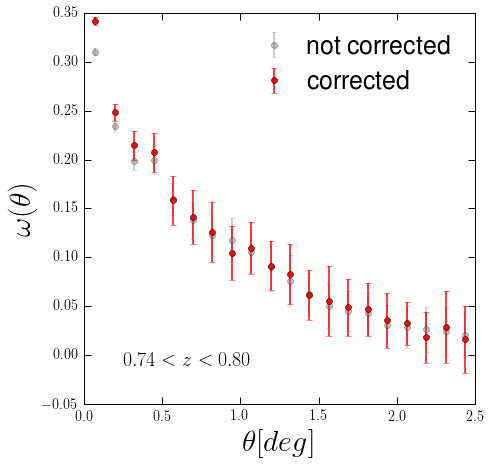

In [28]:
# Weighted 2pt

readw = True
if readw is False:
    
    #cbl.EnumTypes._Weight_ = gal_oii['weight']
    #cat_objs = cbl.Catalogue(cbl.EnumTypes._Galaxy_, cbl.EnumTypes._observedCoordinates_, 
    #                        gal_oii['coords'][:,0],gal_oii['coords'][:,1],gal_oii['redshift'], cbl.EnumTypes._Weight_,
    #                         cosmology, cbl.EnumTypes._degrees_)
    
    cat_objs = cbl.Catalogue(cbl.EnumTypes._Galaxy_, cbl.EnumTypes._observedCoordinates_, 
                             gal_oii_clean['coords'][:,0],gal_oii_clean['coords'][:,1],gal_oii_clean['redshift'], 
                             gal_oii_clean['weight'], cosmology, cbl.EnumTypes._degrees_)


    
    ran_objs = cbl.Catalogue(cbl.EnumTypes._RandomObject_, cbl.EnumTypes._observedCoordinates_,
                            ran_mask_clean['coords'][:,0].astype(float),
                             ran_mask_clean['coords'][:,1].astype(float),ran_mask_clean['redshift'],cosmology, 
                            cbl.EnumTypes._degrees_)

    

    angMin = 0.01                #// minimum angular separation 
    angMax = 2.5                  #// maximum angular separation 
    nbins = 20                      #// number of bins
    shift = 0.5                  #// shift used to set the bin centre 
    angularUnits = cbl.EnumTypes._degrees_

    twopt = cbl.TwoPointCorrelation1D_angular(cat_objs, ran_objs,cbl.EnumTypes._linear_, 
                                              angMin, angMax, nbins, shift, angularUnits)
    cbl.set_ObjectRegion_SubBoxes(cat_objs,ran_objs,3,3,3)

    twopt.measure(cbl.EnumTypes._Jackknife_,'./')
    twopt.write('./', 'test2');
    xxc = np.asarray(twopt.xx())
    xi1Dc = np.asarray(twopt.xi1D())
    error1Dc = np.asarray(twopt.error1D())
else:
    xxc, xi1Dc, error1Dc = np.loadtxt('test2',unpack=True)


fig,ax = plt.subplots(1,figsize=(7,7))
ax.errorbar(xx, xi1D, xx*error1D, fmt='o',
             color='gray', label='not corrected',alpha=0.5)
ax.errorbar(xxc, xi1Dc, xxc*error1Dc, fmt='o',
             color='red', label='corrected')
ax.text(0.1,.10,r'$%.2f<z<%.2f$'%(0.74,0.8),transform=ax.transAxes,fontsize=20)
ax.legend(fontsize=25)
#ax.set_ylim([0.02,0.15])
#plt.yscale('log')
#plt.xscale('log')

ax.set_xlabel(r'$\theta [deg]$',fontsize=30)
ax.set_ylabel(r'$\omega(\theta)$',fontsize=30)
plt.savefig('w_elgcand.pdf',bbox_inches='tight')

print xxc, xi1Dc
print cbl.EnumTypes._Weight_

In [16]:
#Files for Marulli

gals = 'gals.data'
rans = 'rans.data'

fd = open(gals,'w')

print len(gal_oiin['tile_id'])

for i in range(len(gal_oiin['tile_id'])):
    fd.write('%.3f %.3f %.3f\n' % (gal_oiin['coords'][i,0], 
                                  gal_oiin['coords'][i,1],
                                  gal_oiin['weight'][i]))


fd.close()



ff = open(rans,'w')
for i in range(len(ran_mask['tile_id'])):
    ff.write('%.3f %.3f \n' % (ran_mask['coords'][i,0], 
                                  ran_mask['coords'][i,1],
                                  ))

ff.close()


15752


KeyError: 'weight'

In [ ]:
%matplotlib inline
plt.figure('xx',figsize=(10,10))


plt.plot(ran_mask['coords'][:,0],ran_mask['coords'][:,1],'k,')
plt.plot(gal_oiin['coords'][:,0],gal_oiin['coords'][:,1],',',color='yellow')
plt.xlim([180,220])
plt.ylim([20,60])